# Timeseries Classification
## Instructions for use:

1. Update the INPUT_DIR to the output folder you got from running GP_VAE_generation.ipynb and you used also in TimeGAN notebook. In this folder you have the generated data to be used for time-series classification 
2. Run the notebook


In [1]:
INPUT_DIR = '/content/drive/MyDrive/AML_Project/part2/gp_vae_for_data_generation/outputs/20220821-154051'

In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import time
from pathlib import Path
from google.colab import drive

# Google Drive linkage
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Healing MNIST

In [4]:
import numpy as np
import scipy.ndimage
import random
from tensorflow.keras.datasets import mnist


def apply_square(img, square_size):
    img = np.array(img)
    img[:square_size, :square_size] = 255
    return img


def apply_noise(img, bit_flip_ratio):
    img = np.array(img)
    mask = np.random.random(size=(28,28)) < bit_flip_ratio
    img[mask] = 255 - img[mask]
    return img


def get_rotations(img, rotation_steps):
    for rot in rotation_steps:
        img = scipy.ndimage.rotate(img, rot, reshape=False)
        yield img


def binarize(img):
    return (img > 127).astype(np.int)


def heal_image(img, seq_len, square_count, square_size, noise_ratio, max_angle):
    squares_begin = np.random.randint(0, seq_len - square_count)
    squares_end = squares_begin + square_count

    rotations = []
    rotation_steps = np.random.normal(size=seq_len, scale=max_angle)
    
    direction = random.randint(0, 1)
    if direction == 0:
      rotation_steps = abs(rotation_steps)
    else:
       rotation_steps = abs(rotation_steps)*-1
    rotation_steps = np.sort(rotation_steps)

    for idx, rotation in enumerate(get_rotations(img, rotation_steps)):
        # Don't add the squares right now
        # if idx >= squares_begin and idx < squares_end:
        #     rotation = apply_square(rotation, square_size)
        
        # Don't add noise for now
        # noisy_img = apply_noise(rotation, noise_ratio)
        noisy_img = rotation
        binarized_img = binarize(noisy_img)
        rotations.append(binarized_img)

    return rotations, rotation_steps, direction


class HealingMNIST():
    def __init__(self, seq_len=10, square_count=3, square_size=5, noise_ratio=0.15, digits=range(10), max_angle=10, max_number_per_class=10000):
        lables_counts = {}
        (x_train, y_train),(x_test, y_test) = mnist.load_data()
        mnist_train = [(img,label) for img, label in zip(x_train, y_train) if label in digits]
        mnist_test = [(img, label) for img, label in zip(x_test, y_test) if label in digits]

        train_images = []
        test_images = []
        train_rotations = []
        test_rotations = []
        train_labels = []
        test_labels = []

        for img, label in mnist_train:
            
            if label in lables_counts:
              lables_counts[label] += 1
            else:
              lables_counts[label] = 0
            if lables_counts[label] >= max_number_per_class:
                continue

            train_img, train_rot, direction = heal_image(img, seq_len, square_count, square_size, noise_ratio, max_angle)
            train_images.append(train_img)
            train_rotations.append(train_rot)
           
            train_labels.append(str(label) + "_" + str(direction))

        for img, label in mnist_test:
            test_img, test_rot, direction = heal_image(img, seq_len, square_count, square_size, noise_ratio, max_angle)
            test_images.append(test_img)
            test_rotations.append(test_rot)
            test_labels.append(str(label) + "_" + str(direction))
        _,train_labels = np.unique(train_labels, return_inverse=True)
        _,test_labels = np.unique(test_labels, return_inverse=True)
        self.train_images = np.array(train_images)
        self.test_images = np.array(test_images)
        self.train_rotations = np.array(train_rotations)
        self.test_rotations = np.array(test_rotations)
        self.train_labels = np.array(train_labels)
        self.test_labels = np.array(test_labels)

In [5]:
data = HealingMNIST()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


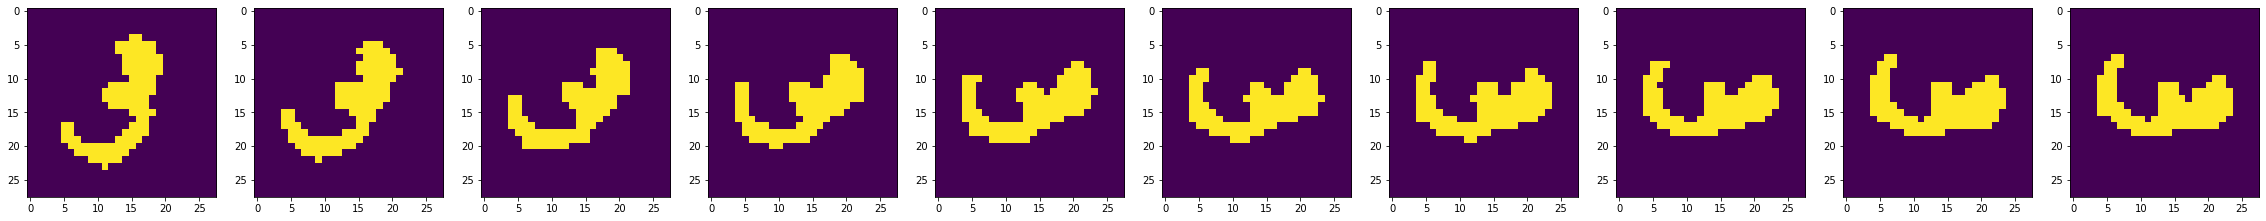

In [6]:
i=10
f, axarr = plt.subplots(1,10,figsize=(40, 15))
axarr[0].imshow(data.train_images[i][0].reshape(28,28))
axarr[1].imshow(data.train_images[i][1].reshape(28,28))
axarr[2].imshow(data.train_images[i][2].reshape(28,28))
axarr[3].imshow(data.train_images[i][3].reshape(28,28))
axarr[4].imshow(data.train_images[i][4].reshape(28,28))
axarr[5].imshow(data.train_images[i][5].reshape(28,28))
axarr[6].imshow(data.train_images[i][6].reshape(28,28))
axarr[7].imshow(data.train_images[i][7].reshape(28,28))
axarr[8].imshow(data.train_images[i][8].reshape(28,28))
axarr[9].imshow(data.train_images[i][9].reshape(28,28))
plt.show()

## Limited Data

In [7]:
data = HealingMNIST()
data2 = np.load(INPUT_DIR + '/train_data.npz')
x_train, y_train = data2['x_train'], data2['y_train']
x_test, y_test = data.test_images.reshape(data.test_images.shape[0],data.test_images.shape[1], data.test_images.shape[2] * data.test_images.shape[3]), data.test_labels
x_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(6000, 10, 784)

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [8]:
num_classes = len(np.unique(y_train))
num_classes

20

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

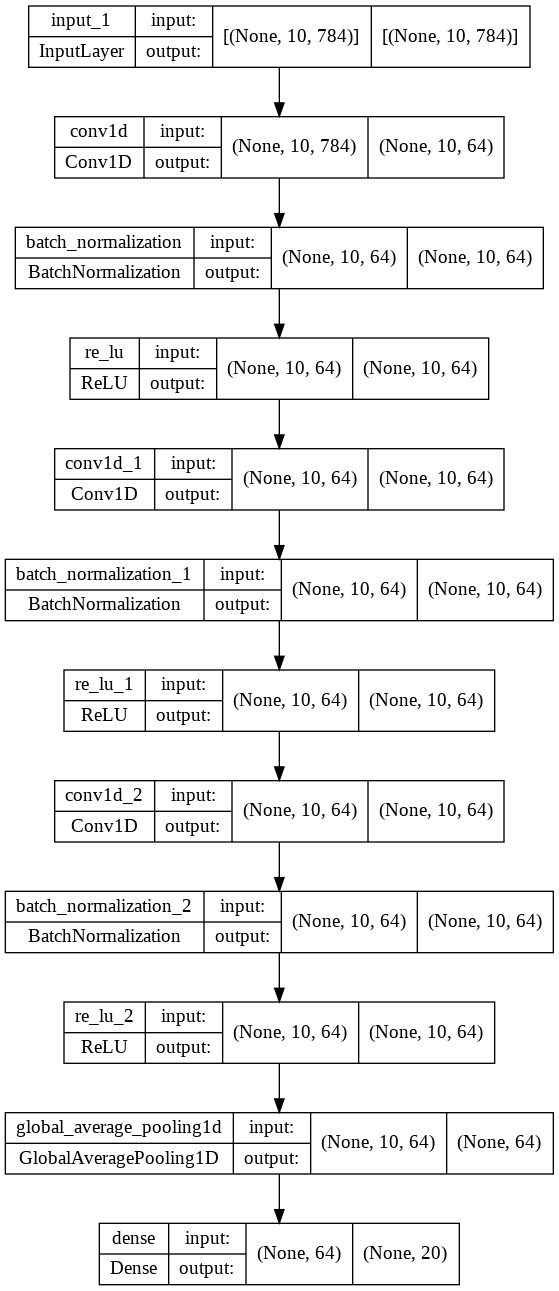

In [9]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [10]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "limited_data_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
150/150 [==============================] - 4s 7ms/step - loss: 0.9372 - sparse_categorical_accuracy: 0.7892 - val_loss: 4.9176 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/500
150/150 [==============================] - 1s 5ms/step - loss: 0.3327 - sparse_categorical_accuracy: 0.9210 - val_loss: 6.6474 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/500
150/150 [==============================] - 1s 5ms/step - loss: 0.2152 - sparse_categorical_accuracy: 0.9454 - val_loss: 7.7698 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/500
150/150 [==============================] - 1s 5ms/step - loss: 0.1363 - sparse_categorical_accuracy: 0.9681 - val_loss: 8.1399 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/500
150/150 [==============================] - 1s 5ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.9729 - val_loss: 8.5426 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50

## Evaluate model on test data

In [11]:
model = keras.models.load_model("limited_data_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 1s 3ms/step - loss: 1.4685 - sparse_categorical_accuracy: 0.7135
Test accuracy 0.7135000228881836
Test loss 1.4685369729995728


## Plot the model's training and validation loss

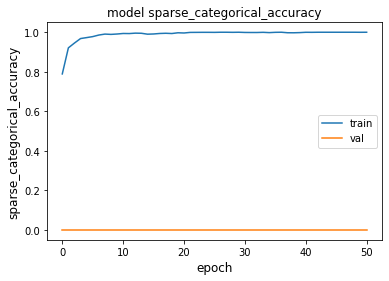

In [12]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

## Limited Data Plus Syntetic GP-VAE Generated Data

In [13]:
data2 = np.load(INPUT_DIR + '/generated_data/imputed_no_gt.npy')
data2.shape

(6000, 10, 784)

In [14]:
x_train_saved = x_train.copy()
y_train_saved = y_train.copy()

In [15]:
x_train, y_train = np.concatenate((x_train, data2)), np.concatenate((y_train, y_train))
x_train.shape, y_train.shape

((12000, 10, 784), (12000,))

## Train Model

In [26]:
epochs = 1000
batch_size = 32

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "generated_data_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
300/300 [==============================] - 3s 6ms/step - loss: 0.7851 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.6113 - val_sparse_categorical_accuracy: 0.8171 - lr: 0.0010
Epoch 2/1000
300/300 [==============================] - 2s 5ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.9371 - val_loss: 0.2793 - val_sparse_categorical_accuracy: 0.9229 - lr: 0.0010
Epoch 3/1000
300/300 [==============================] - 2s 5ms/step - loss: 0.1750 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.2175 - val_sparse_categorical_accuracy: 0.9329 - lr: 0.0010
Epoch 4/1000
300/300 [==============================] - 2s 5ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.2053 - val_sparse_categorical_accuracy: 0.9508 - lr: 0.0010
Epoch 5/1000
300/300 [==============================] - 1s 5ms/step - loss: 0.1007 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.2202 - val_sparse_categorical_accuracy: 0.9488 - lr: 0.0010
Epoch 6/1000
300/300 [===

## Model Evaluation 

In [27]:
model = keras.models.load_model("generated_data_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 1s 3ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.9449
Test accuracy 0.9448999762535095
Test loss 0.2797108292579651


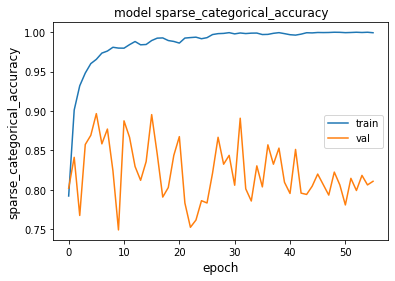

In [18]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

## Limited Data Plus Syntetic Time GAN Generated Data

In [19]:
data2 = np.load(INPUT_DIR + '/time_gan_data_new.npy')
data2.shape

(6000, 10, 784)

In [20]:
y_train_new = np.repeat([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], data2.shape[0]/20)
y_train_new.shape

(6000,)

In [21]:
x_train, y_train = np.concatenate((x_train_saved, data2)), np.concatenate((y_train_saved, y_train_new))
x_train.shape, y_train.shape

((12000, 10, 784), (12000,))

## Train Model

In [28]:
epochs = 1000
batch_size = 32

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "time_gan_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
300/300 [==============================] - 3s 6ms/step - loss: 0.7738 - sparse_categorical_accuracy: 0.8271 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.7912 - lr: 0.0010
Epoch 2/1000
300/300 [==============================] - 2s 5ms/step - loss: 0.2636 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.3328 - val_sparse_categorical_accuracy: 0.9104 - lr: 0.0010
Epoch 3/1000
300/300 [==============================] - 2s 5ms/step - loss: 0.1733 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.1561 - val_sparse_categorical_accuracy: 0.9529 - lr: 0.0010
Epoch 4/1000
300/300 [==============================] - 2s 5ms/step - loss: 0.1187 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.2138 - val_sparse_categorical_accuracy: 0.9221 - lr: 0.0010
Epoch 5/1000
300/300 [==============================] - 2s 5ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.1738 - val_sparse_categorical_accuracy: 0.9413 - lr: 0.0010
Epoch 6/1000
300/300 [===

## Model Evaluation

In [29]:
model = keras.models.load_model("time_gan_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 1s 4ms/step - loss: 0.2546 - sparse_categorical_accuracy: 0.9413
Test accuracy 0.9412999749183655
Test loss 0.25458580255508423


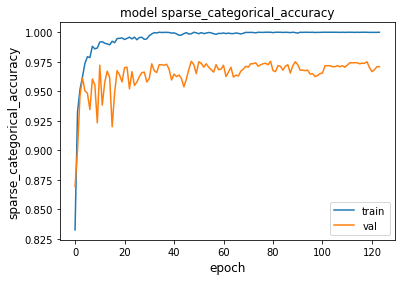

In [24]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()